In [29]:
"""
Here you can see grid structure of a star. There is one ghost cell in center of star, so rf[2] 
is a center of a neutron star.

  |------|------|------|----- ... ------|------|
rf[1]  rc[1]  rf[2]  rc[2]           rc[end] rf[end]
"""


R=2;
rho_max=1;
steps=102;
dr=R/(steps-2);

#radial coordiate of cell faces
r_f=zeros(steps,1)
for i in 1:steps
    r_f[i]=(i-2)*dr
end

#radial coordiate of brycenter of cells
r_c=zeros(steps-1,1)
for i in 1:steps-1
    r_c[i]=sqrt((r_f[i+1]^3-r_f[i]^3)/(3*(r_f[i+1]-r_f[i])))
end
r_c[1]=-r_c[1]

#background density in both cell interface and cell brycenter
rho_c=zeros(steps-1)
for ir in 1:steps-1
rho_c[ir]=max(rho_max * sin(pi*r_c[ir]/R)/(pi*r_c[ir]/R),10^(-10))
end

rho_f=zeros(steps)
for ir in 1:steps
rho_f[ir]= max(rho_max * sin(pi*r_f[ir]/R+10^(-15))/(pi*r_f[ir]/R+10^(-15)),10^(-10))
end

#mass of a star
M_f=zeros(steps)
for i in 2:steps-1
    M_f[i+1]=M_f[i]+4*pi*(r_f[i+1]^3-r_f[i]^3)*rho_c[i]/3
end
M_f[1]=M_f[3]

#gravitational acceleration
g_f =@. M_f/r_f^2
g_f[2]=0
        
g_c=zeros(steps-1)
for i in 1:steps-1
g_c[i]=g_f[i] + (g_f[i+1]-g_f[i])*(r_c[i]-r_f[i])/(r_f[i+1]-r_f[i])
end
g_c[1]=g_c[2];

In [24]:
#Let's define all necessary variables
ur_list=Any[]
up_list=Any[]
rho_list=Any[]
fluxL=zeros(3,steps)
fluxR=zeros(3,steps)
source=zeros(3,steps-1)
wL=zeros(3,steps) 
wR=zeros(3,steps)
wpL=zeros(3,steps) 
wpR=zeros(3,steps) 
numflux=zeros(3,steps)
slopeL=zeros(3,steps) 
slopeR=zeros(3,steps)
slopeC=zeros(3,steps) 
slope=zeros(3,steps) 
w=zeros(3,steps-1,2) 
w1=zeros(3,steps-1,2)
rhs=zeros(3,steps)
rhs1=zeros(3,steps)
rhs2=zeros(3,steps)
speed=zeros(steps)
CFL=0.1;
gamma=2;
p_c=@. rho_c^2;
p_f=@. rho_f^2;
cs_squared_c= @. gamma*p_c/rho_c;
cs_squared_f= @. gamma*p_f/rho_f;
time=0;
iter=0;
Tmax=2;
l=2;
dt=0;

#minmod limiter
function minmod(slopeL, slopeR)
     return 1/2*(sign(slopeR)+sign(slopeL))*min(abs(slopeL),abs(slopeR)) 
end

#CFL condition
function compute_time_step(speed)
        sp=maximum(abs.(speed))
    return CFL * dr / sp
end

#initial conditions
for ir in 1:steps-1
    w[1,ir,1]= 0
    w[2,ir,1]= 0
    w[3,ir,1]= sin(2*pi*r_c[ir]/R)
end 

function RHS(w)
        
    #boundary condition at the call center. Here w[1,1,1], w[2,1,1] and w[3,1,1] are correspondingly rho_f*u_r, rho_f*u_p and rho_prime
    w[1,1,1]=-w[1,2,1]
    w[2,1,1]=-w[2,2,1]
    w[3,1,1]=w[3,2,1]
        
    for iw in 1:3
        for ir in 2:steps-2
            #slope of i-th cell center
            slopeL[iw,1]=0 
            slopeL[iw,ir]=(w[iw,ir,1]-w[iw,ir-1,1])/(r_c[ir]-r_c[ir-1])
            
            slopeR[iw,ir]=(w[iw,ir+1,1]-w[iw,ir,1])/(r_c[ir+1]-r_c[ir])
            slopeR[iw,end]=(0-w[iw,end,1])/dr
            
            slope[iw,ir]=minmod(slopeL[iw,ir], slopeR[iw,ir])
            wL[iw,ir]= w[iw,ir,1]+slope[iw,ir]*(r_f[ir]-r_c[ir])
            wR[iw,ir]= w[iw,ir,1]+slope[iw,ir]*(r_f[ir+1]-r_c[ir])
        end        
    end
      
    #wpL and wpR are values of variables at the left and right side of a cell interface
   for iw in 1:3
        for ir in 2:steps-1
            wpL[iw,ir]=wR[iw,ir-1]
            wpR[iw,ir]=wL[iw,ir]
        end
    end
    
    #flux at the left and right side of a cell interface
    for ir in 2:steps-1
            
        fluxL[1,ir]= -r_f[ir]^2 * cs_squared_f[ir] * wpL[3,ir];              
        fluxL[2,ir]=0;
        fluxL[3,ir]= -r_f[ir]^2 * wpL[1,ir];
    
        fluxR[1,ir]= -r_f[ir]^2 * cs_squared_f[ir] * wpR[3,ir];     
        fluxR[2,ir]=0;
        fluxR[3,ir]= -r_f[ir]^2 * wpR[1,ir];
    end
        
    for ir in 2:steps-1
        speed1=abs(sqrt(cs_squared_f[ir]) + wpL[1,ir]/rho_f[ir])
        speed2=abs(sqrt(cs_squared_f[ir]) - wpL[1,ir]/rho_f[ir])
        speed3=abs(sqrt(cs_squared_f[ir]) + wpR[1,ir]/rho_f[ir])
        speed4=abs(sqrt(cs_squared_f[ir]) - wpR[1,ir]/rho_f[ir])
        speed[ir]=max(speed1,speed2,speed3,speed4)
    end
    
    sp=maximum(speed)
    
    #Lax-Friedrichs method to calculate numerical flux at the cell interface
    for iw  in 1:3
        for ir in 2:steps-1
            numflux[iw,ir] = 0.5*(fluxL[iw,ir]+fluxR[iw,ir]) + sp/2*(wpR[iw,ir] - wpL[iw,ir])*r_f[ir]^2
        end
    end
        
    #Source terms
    for ir in 2:steps-2
        source[1,ir]= cs_squared_c[ir]*(r_f[ir+1]^2-r_f[ir]^2)*w[3,ir,1]+1/3 * w[3,ir,1]*g_c[ir]*(r_f[ir]^3-r_f[ir+1]^3)
        source[2,ir]= 1/2*cs_squared_c[ir]*w[3,ir,1]*(r_f[ir]^2-r_f[ir+1]^2)
        source[3,ir]= 1/2*l*(l+1)*w[2,ir,1]*(r_f[ir+1]^2-r_f[ir]^2)
    end
       
    #right hand side of a final equation
    for iw  in 1:3
        for ir in 2:steps-2
            rhs[iw,ir]=3*(-numflux[iw,ir]+numflux[iw,ir+1]+source[iw,ir])/(r_f[ir+1]^3-r_f[ir]^3)
        end
    end

    return rhs
end

#now let's iterate over time
using ProgressMeter
#@showprogress 0.01 "Computing..." for i in round(Tmax/dt, digits=0)
while time<=Tmax
    
    if iter % 1 == 0
            push!(rho_list, copy(w[3,1:end,1]))
            push!(ur_list, copy(w[1,1:end,1] ./ rho_c[1:end]))
            push!(up_list, copy(w[2,1:end,1] ./ rho_c[1:end]))
    end
    
    #Runge-Kutta 2 scheme
    rhs1 = RHS(w)
    dt = compute_time_step(speed)
    
    for iw  in 1:3
        for ir in 1:steps-2
            w1[iw,ir,1]=w[iw,ir,1]+0.5*dt*rhs1[iw,ir]  
        end
    end
   
    rhs2 =RHS(w1)
    
    for iw  in 1:3
        for ir in 1:steps-2
           w[iw,ir,2]=(w[iw,ir,1]+dt*rhs2[iw,ir])          
        end
    end
    
    #re-definition of boundary condition
    w[1,1,2]=-w[1,2,2]
    w[2,1,2]=-w[2,2,2]
    w[3,1,2]=w[3,2,2]
    
    w[:,:,1]=w[:,:,2]  
 
    global iter=iter+1
    global time=time + dt
end
    
print("Time: ", time, "\n")   

Time: 2.0003353522901457


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
[ Info: Saved animation to /home/abdurakhmon/neutron_stars/rho_l=2.gif


Plots.AnimatedGif("/home/abdurakhmon/neutron_stars/rho_l=2.gif")
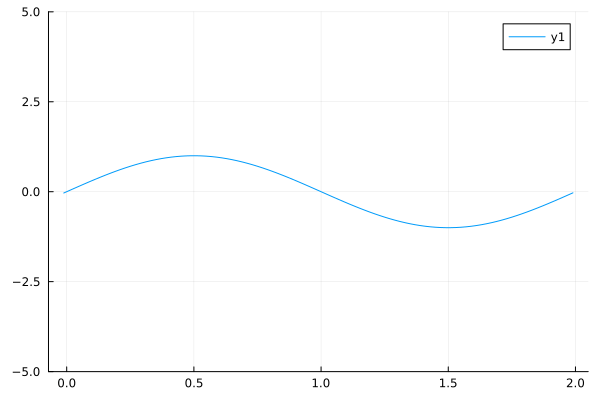

In [26]:
#animation of time evolution of density perturbation vs r_c plot
using JLD
using Plots
using IJulia
using ProgressMeter
time = 0
iter = 0
k=10 #size of steps
n=length(rho_list)
p=Progress(Int(round(n/k,digits=0)))
anim = @animate for i in 1:k:n
    
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
    #time_approx = round(time,digits=1);
    plot(r_c,rho_list[i],ylim=(-5,5))

    next!(p)
    
end
gif(anim, "rho_l=2.gif",fps=60)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
[ Info: Saved animation to /home/abdurakhmon/neutron_stars/ur_l=2.gif


Plots.AnimatedGif("/home/abdurakhmon/neutron_stars/ur_l=2.gif")
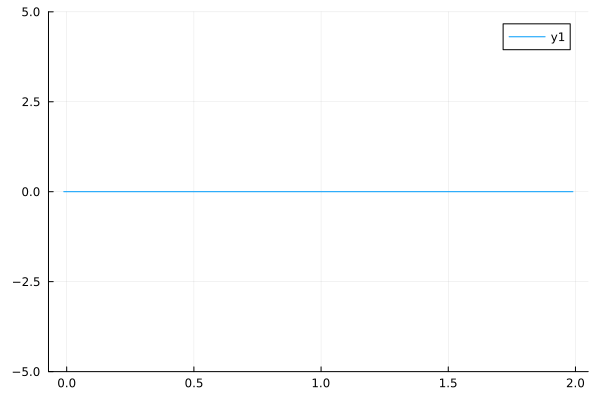

In [27]:
#animation of time evolution of ur vs r_c plot
using JLD
using Plots
using IJulia
using ProgressMeter
time = 0
iter = 0
k=10 #size of steps
n=length(ur_list)
p=Progress(Int(round(n/k,digits=0)))
anim = @animate for i in 1:k:n
    
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
    #time_approx = round(time,digits=1);
    plot(r_c,ur_list[i],ylim=(-5,5))

    next!(p)
    
end
gif(anim, "ur_l=2.gif",fps=60)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
[ Info: Saved animation to /home/abdurakhmon/neutron_stars/up_l=2.gif


Plots.AnimatedGif("/home/abdurakhmon/neutron_stars/up_l=2.gif")
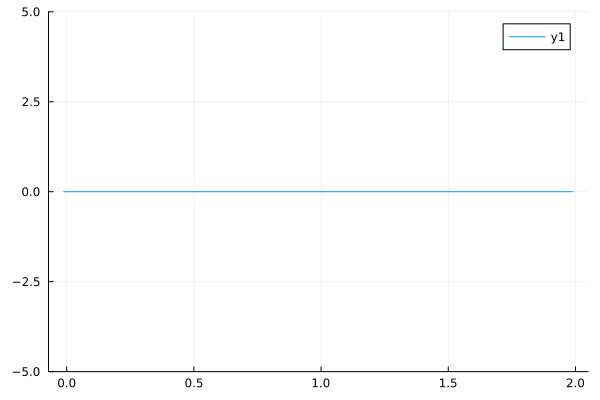

In [28]:
#animation of time evolution of up vs r_c plot
using JLD
using Plots
using IJulia
using ProgressMeter
time = 0
iter = 0
k=10 #size of steps
n=length(up_list)
p=Progress(Int(round(n/k,digits=0)))
anim = @animate for i in 1:k:n
    
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
    #time_approx = round(time,digits=1);
    plot(r_c,up_list[i],ylim=(-5,5))

    next!(p)
    
end
gif(anim, "up_l=2.gif",fps=60)
